# Crime Analytics in Seattle and San Francisco

For this analysis, we have access to 2 months of real crime data for Summer 2014 in San Francisco and Seattle.

* SF's data has been extracted from [their open-data portal](https://data.sfgov.org/Public-Safety/SFPD-Incidents-from-1-January-2003/tmnf-yvry) into this repository under **data/sanfrancisco_incidents_summer_2014.csv**
* Seattle's data has been extracted from [their open-data portal](https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f) into this repository under **data/sanfrancisco_incidents_summer_2014.csv**

The goal of this study is to explore these cities' nightlife in a criminology context, to figure out which crimes are more frequent at night, which neighborhoods are most impacted, and how both cities compare.

I chose IPython notebook to perform this analysis for several reasons:

* **Convenience**: I can run each cell independently, making it easy to go back and forth to rerun specific parts of my analysis without having to run everything from scratch.
* **Reproducibility**: Anyone reading this notebook can easily take it and run it on their own machine directly without any extra work needed.

In [1]:
YEAR = 2014
PERIOD = "summer"
TYPE = "incidents"
DATA_DIR = "data"
SF = "sanfrancisco"
SEATTLE = "seattle"

To do this analysis, we are using Python's excellent [pandas](http://pandas.pydata.org/) library which allows us to represent the data as **DataFrames** which makes subsequent analysis much easier than doing it by hand.

Below we are creating 2 DataFrames:

* `sf`: contains San Francisco's crime data for Summer 2014.
* `seattle`: contains Seattle's crime data for Summer 2014.

In [3]:
# Load data into pandas DataFrames
import os
import pandas as pd

sf_filename = os.path.join(DATA_DIR, "%s_%s_%s_%d.csv" % (SF, TYPE, PERIOD, YEAR))
sf = pd.read_csv(sf_filename)
sf_nrows = sf.shape[0]
print "Read SF data from %s yielded %d rows" % (sf_filename, sf_nrows)

seattle_filename = os.path.join(DATA_DIR, "%s_%s_%s_%d.csv" % (SEATTLE, TYPE, PERIOD, YEAR))
seattle = pd.read_csv(seattle_filename)
seattle_nrows = seattle.shape[0]
print "Read Seattle data from %s yielded %d rows" % (seattle_filename, seattle_nrows)

assert sf_nrows == len(open(sf_filename).readlines()) - 1 != 0
assert seattle_nrows == len(open(seattle_filename).readlines()) - 1 != 0

Read SF data from data/sanfrancisco_incidents_summer_2014.csv yielded 28993 rows
Read Seattle data from data/seattle_incidents_summer_2014.csv yielded 32779 rows


As with any data analysis task, we start by sampling some random data in `sf` to just look at it and get a feeling on what we can get out of it.

For example, we can see that some columns are not really useful for what we try to accomplish, like `IncidntNum` or `PdId` which are just SFPD internal IDs.
And on the other hand, some data like `X` or `Y` will be useful for any kind of geospatial analysis, as will the `Date` and `Time` for temporal analysis.

In [4]:
sf.sample(n=5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
11751,140624900,MISSING PERSON,FOUND PERSON,Sunday,07/27/2014,09:00,INGLESIDE,PSYCHOPATHIC CASE,100 Block of DELTA ST,-122.407996,37.716734,"(37.7167337928807, -122.407995830757)",14062490075000
27214,140475377,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Friday,06/06/2014,18:30,TARAVAL,NONE,2300 Block of KIRKHAM ST,-122.485981,37.759375,"(37.7593749309263, -122.485980962978)",14047537707020
9814,146177440,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Saturday,08/02/2014,00:55,MISSION,NONE,2700 Block of 20TH ST,-122.408436,37.759330,"(37.7593301145153, -122.408436397631)",14617744006372
13583,140606152,NON-CRIMINAL,COURTESY REPORT,Monday,07/21/2014,17:45,BAYVIEW,UNFOUNDED,4500 Block of 3RD ST,-122.389877,37.736742,"(37.7367416338184, -122.389877486888)",14060615268030
26281,140481625,NON-CRIMINAL,FOUND PROPERTY,Tuesday,06/10/2014,00:01,INGLESIDE,NONE,100 Block of HAMERTON AV,-122.437665,37.733975,"(37.7339751507837, -122.437664579467)",14048162572000


We do the same for `seattle` and there are 2 important things to notice here:

* Similarly to `sf`, several columns are not useful and can be discarded.
* Some columns have the same meaning as in `sf` but are called differently, like `Longitude` and `Latitude` which correspond respectively to `X` and `Y` in `sf`.
* The schema is completely different from `sf`, and in this state making comparisons between the 2 cities will be hard.

In [5]:
seattle.sample(n=5)

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
21210,1040279,2014217348,2205,0,BURGLARY-NOFORCE-NONRES,2200,BURGLARY,07/05/2014 07:43:00 AM,07/05/2014 07:40:00 AM,NaN,25XX BLOCK OF SW BARTON ST,F,F2,11400.3007,-122.365221,47.521023,"(47.52102254, -122.365221007)",7,2014
26373,1004195,2014196998,X,47,PROPERTY FOUND,X,STOLEN PROPERTY,06/20/2014 09:34:00 AM,06/20/2014 09:34:00 AM,NaN,34XX BLOCK OF E MERCER ST,C,C3,6300.4005,-122.287543,47.624935,"(47.624934683, -122.287542538)",6,2014
7735,41132,2014266021,2305,0,THEFT-CARPROWL,2300,CAR PROWL,08/11/2014 06:41:00 PM,08/11/2014 06:00:00 PM,08/11/2014 06:30:00 PM,55XX BLOCK OF 15 AV NW,B,B1,4700.3017,-122.376214,47.669055,"(47.669054688, -122.376214119)",8,2014
9201,41881,2014260441,2305,0,THEFT-CARPROWL,2300,CAR PROWL,08/07/2014 09:19:00 AM,07/30/2014 11:45:00 AM,NaN,20XX BLOCK OF 2 AV,M,M1,8002.1004,-122.342403,47.612117,"(47.612117499, -122.3424026)",7,2014
5113,39532,2014275914,2399,3,THEFT-OTH,2300,OTHER PROPERTY,08/19/2014 01:44:00 PM,08/18/2014 04:25:00 AM,NaN,44XX BLOCK OF GREEN LAKE WY N,B,B3,5000.3023,-122.347002,47.660979,"(47.660979279, -122.347001981)",8,2014


At that point it becomes clear that, before we can do any kind of meaningful data exploration and analysis, we need to pre-process the data. In particular, the following tasks will be required:

* Get rid of columns that do not bring any value for our goals.
* Rename columns so that identical fields are called the same in both DataFrames.
* Process existing columns to extra new features that will be used for our analysis.

## Data Preprocessing and Normalization

### San Francisco

There are several columns in `sf` that have data mapping to other columns in `seattle`, but they are called differently. Specifically:

* `X` in `sf` has a 1:1 relationship to `Longitude` in `seattle`.
* `Y` in `sf` has a 1:1 relationship to `Latitude` in `seattle`.
* `PdDistrict` in `sf` has a 1:1 relationship to `District/Sector` in `seattle`. To simplify we want to name both `District`.
* `Descript` in `sf` has a 1:1 relationship to `Summarized Offense Description` in `seattle`. To simplify we want to name both `Description`.

So in a first step, we will modify `sf` to rename these columns in place.

In [17]:
sf.rename(columns = {"X": "Longitude", "Y": "Latitude", "PdDistrict": "District", "Descript": "Description"}, 
          inplace=True)

Next we want to take the existing columns, process them, and extract new features which may or may not be useful during our data exploration process later on. In particular:

* Since we are trying to get both `sf` and `seattle` normalized so they can fit in a single unified DataFrame, we need to indicate for each row the `City` so that we can later one have control on which city we're processing.
* We have the `Date` field in format _mm/dd/yyyy_, but if we're doing temporal analysis it would be useful to have access to individual units separately, so we'd want to have 1 column being the `DayOfMonth`, another one the `Month` and a last one the `Year`.

In [18]:
sf["City"] = pd.Series([SF]*sf.shape[0], index=sf.index)
sf["DayOfMonth"] = sf.Date.map(lambda x: int(x.split("/")[1]))
sf["Month"] = sf.Date.map(lambda x: int(x.split("/")[0]))
sf["Year"] = sf.Date.map(lambda x: int(x.split("/")[2]))

Another feature we want to extract is the `TimeBin`. We currently have access to the time of each incident under `Time` in format _HH:MM_, but if we want to perform time-based aggregation this is not very convenient.

Instead, what we want is to just keep the hour of the incident, and add it to the `TimeBin`. Like that we have an integer representation of the time which is easier to visualize and work with, and we can aggregate hourly data very easily.

In [19]:
# Function that takes a Time as HH:MM and returns an int representing the hour
def time_bin(t, bin_size=30):
    hour, mins = t.split(":")
    return int(hour)
    
sf["TimeBin"] = sf.Time.map(time_bin)

Now that we have all our new features, we just need to `drop` the columns that are not useful for us. We will drop the following columns:

* `IncidntNum`: A SFPD internal ID which we can't make use of.
* `PdId`: Another SFPD internal ID.
* `Location`: This is just a combination of columns `X` and `Y` and is redundant.
* `Resolution`: While this tells an interesting story (how the case concluded), there is no such data in `seattle`, so we will not use that.

In [20]:
sf.drop(["IncidntNum", "PdId", "Location", "Resolution"], axis=1, inplace=True, errors="ignore")

We now have everything we need in `sf`, we simply need to create a new DataFrame `sf_normalized` that will have a specific order of the columns. This is because `seattle` has a completely different order, so we want to make sure both DataFrames will have the exact same schema so we can fit them into a single DataFrame ultimately.

In [25]:
# Reindex the DataFrame
columns_index = ["City", "DayOfMonth", "DayOfWeek", "Month", "Year", "Time", "TimeBin",
                    "Longitude", "Latitude", "Address", "District", 
                    "Category", "Description"
                   ]
sf_normalized = sf[columns_index]
sf_normalized.sample(n=5)

,City,DayOfMonth,DayOfWeek,Month,Year,Time,TimeBin,Longitude,Latitude,Address,District,Category,Description
2011,sanfrancisco,25,Monday,8,2014,19:25,19,-122.434564,37.784150,GEARY BL / STEINER ST,NORTHERN,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO
13317,sanfrancisco,22,Tuesday,7,2014,11:50,11,-122.398913,37.788629,500 Block of MISSION ST,SOUTHERN,OTHER OFFENSES,DEFRAUDING TAXI DRIVER
11977,sanfrancisco,26,Saturday,7,2014,15:00,15,-122.418406,37.791757,1500 Block of SACRAMENTO ST,CENTRAL,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE
23513,sanfrancisco,19,Thursday,6,2014,18:30,18,-122.391775,37.780829,0 Block of STANFORD ST,SOUTHERN,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO
623,sanfrancisco,30,Saturday,8,2014,00:38,0,-122.426956,37.769247,2000 Block of MARKET ST,MISSION,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA


### Seattle

We need to go through the same process for `seattle`. As a first step, let's drop the following columns:

* `RMS CDW ID`: A SeattlePD internal ID, no use for us.
* `General Offense Number`: A unique number for each incident. Seems to be a function of the date, but we don't need it.
* `Offense Code`: A unique number identifying each type of offense. This maps to `Offense Type` but is less expressive, so we get rid of it.
* `Offense Code Extension`: Some ID, probably SeattlePD internal stuff.
* `Census Tract 2000`: Census information which is not relevant for our analysis.
* `Location`: This is just a combination of columns `Longitude` and `Latitude` and is redundant.

In [22]:
seattle_drop_columns = ["RMS CDW ID", 
                        "General Offense Number", 
                        "Offense Code", 
                        "Offense Code Extension", 
                        "Summary Offense Code",
                        "Census Tract 2000",
                        "Location"
                       ]
seattle.drop(seattle_drop_columns, axis=1, inplace=True, errors="ignore")

Next we rename the columns which have a different name in `sf`:

* `Hundred Block Location` in `seattle` is similar to `Address` in `sf`.
* `Offense Type` in `seattle` is similar to `Category` in `sf`.
* We want to rename `Summarized Offense Description` to `Description` to make it simpler, like mentioned earlier.
* We want to rename `District/Sector` to `District` to make it simpler, like mentioned earlier.

In [23]:
seattle.rename(columns = {"Hundred Block Location": "Address", "Offense Type": "Category", 
                          "Summarized Offense Description": "Description",
                          "District/Sector": "District"}, 
               inplace=True)

Finally we want to create new features for our analysis, similarly to what we did in `sf`:

* `City` should always be `seattle`.
* For temporal features, there are multiple choices. We could consider the occurrence date (`Occurred Date or Date Range Start`), or reported date (`Date Reported`). By looking at the data we see the date reported is sometimes many months after the alleged occurrence date, so we use the start range of the alleged occurred data for any temporal measure. From that we will create new features `DayOfMonth`, `DayOfWeek`, `Time` and `TimeBin` to match `sf` schema.

In [24]:
import datetime

seattle["City"] = pd.Series([SEATTLE]*seattle.shape[0], index=seattle.index)
seattle["DayOfMonth"] = seattle["Occurred Date or Date Range Start"].map(lambda x: int(x.split(" ")[0].split("/")[1]))
seattle["DayOfWeek"] = seattle["Occurred Date or Date Range Start"] \
    .map(lambda x: datetime.datetime.strptime(x.split(" ")[0], "%m/%d/%Y").strftime("%A"))
seattle["Time"] = seattle["Occurred Date or Date Range Start"] \
    .map(lambda x: datetime.datetime.strptime(x[11:], "%I:%M:%S %p").strftime("%H:%M"))
seattle["TimeBin"] = seattle.Time.map(time_bin)

Now we just need to reindex our DataFrame under a new one called `seattle_normalized`.

In [26]:
# Reindex the DataFrame
seattle_normalized = seattle[columns_index]
seattle_normalized.sample(n=5)

,City,DayOfMonth,DayOfWeek,Month,Year,Time,TimeBin,Longitude,Latitude,Address,District,Category,Description
14869,seattle,22,Tuesday,7,2014,14:20,14,-122.324615,47.708603,4XX BLOCK OF NE NORTHGATE WY,N,THEFT-OTH,OTHER PROPERTY
2996,seattle,25,Monday,8,2014,18:38,18,-122.320771,47.613520,14XX BLOCK OF BROADWAY,E,DISTURBANCE-OTH,DISTURBANCE
23017,seattle,28,Saturday,6,2014,04:00,4,-122.343394,47.731401,140XX BLOCK OF LENORA PL N,N,VEH-THEFT-TRUCK,VEHICLE THEFT
25239,seattle,18,Wednesday,6,2014,05:00,5,-122.294655,47.694765,30XX BLOCK OF NE 91 ST,U,THEFT-MAIL,MAIL THEFT
12253,seattle,29,Tuesday,7,2014,16:31,16,-122.338758,47.604135,10XX BLOCK OF ALASKAN WY,K,WARRARR-MISDEMEANOR,WARRANT ARREST


At that point, we have 2 DataFrames `sf_normalized` and `seattle_normalized` with matching schemas, but we're not done yet.

A particularly important column to analyze distribution of crime data is the `Category`. Unfortunately for us, Seattle and San Francisco police departments have very different ways to label incidents which don't match at all. For example, offenses related to drug trafficking are labelled `DRUG/NARCOTIC` in San Francisco, but in Seattle this is much more granular and there are more than 20 different labels for drug traffick offenses. The problem is that if we need to compare crime categories, if granularity is more different in 1 city then aggregated numbers won't mean anything.

As a result, we need to manually go through the crime categories and see how they map between the 2 cities. Since San Francisco categories are fewer and cover more ground, we will use San Francisco categories as the baseline, and try to map all of Seattle's crime categories into San Francisco categories namespace.

For example, we can say that Seattle's `ASSLT-AGG-WEAPON` matches San Francisco's `ASSAULT` category.

In [82]:
category_subset = {
    "RECKLESS BURNING": "ARSON",
    "THEFT-OTH": "LARCENY/THEFT",
    "BURGLARY-FORCE-NONRES": "BURGLARY",
    "INJURY - ACCIDENTAL": "OTHER OFFENSES",
    "ANIMAL-BITE": "OTHER OFFENSES",
    "ANIMAL-CRUELTY": "OTHER OFFENSES",
    "ANIMAL-OTH": "OTHER OFFENSES",
    "ASSLT-AGG-BODYFORCE": "ASSAULT",
    "ASSLT-AGG-GUN": "ASSAULT",
    "ASSLT-AGG-POLICE-BODYFORCE": "ASSAULT",
    "ASSLT-AGG-POLICE-GUN": "ASSAULT",
    "ASSLT-AGG-POLICE-WEAPON": "ASSAULT",
    "ASSLT-AGG-WEAPON": "ASSAULT",
    "ASSLT-NONAGG": "ASSAULT",
    "ASSLT-NONAGG-POLICE": "ASSAULT",
    "BIAS INCIDENT": "NON-CRIMINAL",
    "BURGLARY-FORCE-RES": "BURGLARY",
    "BURGLARY-NOFORCE-NONRES": "BURGLARY",
    "BURGLARY-NOFORCE-RES": "BURGLARY",
    "BURGLARY-SECURE PARKING-NONRES": "BURGLARY",
    "BURGLARY-SECURE PARKING-RES": "BURGLARY",
    "COUNTERFEIT": "FORGERY/COUNTERFEITING",
    "DISPUTE-CIVIL PROPERTY (AUTO)": "NON-CRIMINAL",
    "DISPUTE-CIVIL PROPERTY (NON AU": "NON-CRIMINAL",
    "DISPUTE-OTH": "NON-CRIMINAL",
    "DISTURBANCE-NOISE": "NON-CRIMINAL",
    "DISTURBANCE-OTH": "NON-CRIMINAL",
    "DRIVE-BY": "OTHER OFFENSES",
    "DUI-DRUGS": "DRIVING UNDER THE INFLUENCE",
    "DUI-LIQUOR": "DRIVING UNDER THE INFLUENCE",
    "ELUDING-FELONY FLIGHT": "RUNAWAY",
    "EMBEZZLE": "EMBEZZLEMENT",
    "ENDANGERMENT": "OTHER OFFENSES",
    "ESCAPE": "RUNAWAY",
    "FALSE REPORT": "OTHER OFFENSES",
    "FIREWORK-POSSESS": "OTHER OFFENSES",
    "FIREWORK-USE": "OTHER OFFENSES",
    "FORGERY-CHECK": "FORGERY/COUNTERFEITING",
    "FORGERY-CREDIT CARD": "FORGERY/COUNTERFEITING",
    "FORGERY-OTH": "FORGERY/COUNTERFEITING",
    "FRAUD-CHECK": "FRAUD",
    "FRAUD-COMPUTER": "FRAUD",
    "FRAUD-CREDIT CARD": "FRAUD",
    "FRAUD-IDENTITY THEFT": "FRAUD",
    "FRAUD-OTHER": "FRAUD",
    "FRAUD-WIRE-ELECTRONIC": "FRAUD",
    "HARASSMENT": "DISORDERLY CONDUCT",
    "HOMICIDE-JUST-GUN": "ASSAULT",
    "HOMICIDE-JUST-WEAPON": "ASSAULT",
    "HOMICIDE-PREMEDITATED-GUN": "ASSAULT",
    "ILLEGAL DUMPING": "NON-CRIMINAL",
    "INJURY - OTHER": "OTHER OFFENSES",
    "LIQUOR LAW VIOLATION": "LIQUOR LAWS",
    "MALICIOUS HARASSMENT": "DISORDERLY CONDUCT",
    "NARC-DRUG TRAFFIC LOITERING": "DRUG/NARCOTIC",
    "NARC-EQUIPMENT/PARAPHENALIA": "DRUG/NARCOTIC",
    "NARC-FORGERY-PRESCRIPTION": "DRUG/NARCOTIC",
    "NARC-FOUND-AMPHETAMINE": "DRUG/NARCOTIC",
    "NARC-FOUND-COCAINE": "DRUG/NARCOTIC",
    "NARC-FOUND-HEROIN": "DRUG/NARCOTIC",
    "NARC-FOUND-MARIJU": "DRUG/NARCOTIC",
    "NARC-FOUND-METH": "DRUG/NARCOTIC",
    "NARC-FOUND-OPIUM": "DRUG/NARCOTIC",
    "NARC-FOUND-OTHER": "DRUG/NARCOTIC",
    "NARC-FOUND-SYNTHETIC": "DRUG/NARCOTIC",
    "NARC-FRAUD-PRESCRIPTION": "DRUG/NARCOTIC",
    "NARC-POSSESS-AMPHETAMINE": "DRUG/NARCOTIC",
    "NARC-POSSESS-COCAINE": "DRUG/NARCOTIC",
    "NARC-POSSESS-HALLUCINOGEN": "DRUG/NARCOTIC",
    "NARC-POSSESS-HEROIN": "DRUG/NARCOTIC",
    "NARC-POSSESS-MARIJU": "DRUG/NARCOTIC",
    "NARC-POSSESS-METH": "DRUG/NARCOTIC",
    "NARC-POSSESS-OTHER": "DRUG/NARCOTIC",
    "NARC-POSSESS-PILL/TABLET": "DRUG/NARCOTIC",
    "NARC-PRODUCE-MARIJU": "DRUG/NARCOTIC",
    "NARC-SELL-AMPHETAMINE": "DRUG/NARCOTIC",
    "NARC-SELL-COCAINE": "DRUG/NARCOTIC",
    "NARC-SELL-HEROIN": "DRUG/NARCOTIC",
    "NARC-SELL-MARIJU": "DRUG/NARCOTIC",
    "NARC-SELL-METH": "DRUG/NARCOTIC",
    "NARC-SELL-SYNTHETIC": "DRUG/NARCOTIC",
    "NARC-SMUGGLE-OTHER": "DRUG/NARCOTIC",
    "OBSTRUCT": "OTHER OFFENSES",
    "PORNOGRAPHY-OBSCENE MATERIAL": "PORNOGRAPHY/OBSCENE MAT",
    "PROP RECOVERED-OTHER AGENCY": "STOLEN PROPERTY",
    "PROPERTY DAMAGE - GRAFFITI": "VANDALISM",
    "PROPERTY DAMAGE-NON RESIDENTIA": "VANDALISM",
    "PROPERTY DAMAGE-RESIDENTIAL": "VANDALISM",
    "PROPERTY FOUND": "STOLEN PROPERTY",
    "PROPERTY LOST": "STOLEN PROPERTY",
    "PROPERTY LOST - POLICE EQUIPME": "STOLEN PROPERTY",
    "PROPERTY STOLEN-POSSESS": "STOLEN PROPERTY",
    "PROPERTY STOLEN-SELL": "STOLEN PROPERTY",
    "PROPERTY STOLEN-TRAFFICKING": "STOLEN PROPERTY",
    "PROSTITUTION LOITERING": "PROSTITUTION",
    "PROSTITUTION PATRONIZING": "PROSTITUTION",
    "PROSTITUTION-ASSIST-PROMOTE": "PROSTITUTION",
    "ROBBERY-BANK-BODYFORCE": "ROBBERY",
    "ROBBERY-BANK-GUN": "ROBBERY",
    "ROBBERY-BANK-WEAPON": "ROBBERY",
    "ROBBERY-BUSINESS-BODYFORCE": "ROBBERY",
    "ROBBERY-BUSINESS-GUN": "ROBBERY",
    "ROBBERY-BUSINESS-WEAPON": "ROBBERY",
    "ROBBERY-RESIDENCE-BODYFORCE": "ROBBERY",
    "ROBBERY-RESIDENCE-GUN": "ROBBERY",
    "ROBBERY-RESIDENCE-WEAPON": "ROBBERY",
    "ROBBERY-STREET-BODYFORCE": "ROBBERY",
    "ROBBERY-STREET-GUN": "ROBBERY",
    "ROBBERY-STREET-WEAPON": "ROBBERY",
    "THEFT OF SERVICES": "LARCENY/THEFT",
    "THEFT-AUTO PARTS": "LARCENY/THEFT",
    "THEFT-AUTOACC": "LARCENY/THEFT",
    "THEFT-BICYCLE": "LARCENY/THEFT",
    "THEFT-BOAT": "LARCENY/THEFT",
    "THEFT-BUILDING": "LARCENY/THEFT",
    "THEFT-CARPROWL": "LARCENY/THEFT",
    "THEFT-COINOP": "LARCENY/THEFT",
    "THEFT-LICENSE PLATE": "LARCENY/THEFT",
    "THEFT-MAIL": "LARCENY/THEFT",
    "THEFT-PKPOCKET": "LARCENY/THEFT",
    "THEFT-PRSNATCH": "LARCENY/THEFT",
    "THEFT-SHOPLIFT": "LARCENY/THEFT",
    "THREATS-KILL": "ASSAULT",
    "THREATS-OTHER": "OTHER OFFENSES",
    "THREATS-WEAPON": "ASSAULT",
    "TRAFFIC": "OTHER OFFENSES",
    "URINATING/DEFECATING-IN PUBLIC": "DISORDERLY CONDUCT",
    "VEH-RCVD-FOR OTHER AGENCY": "VEHICLE THEFT",
    "VEH-THEFT-AUTO": "VEHICLE THEFT",
    "VEH-THEFT-MTRCYCLE": "VEHICLE THEFT",
    "VEH-THEFT-OTHVEH": "VEHICLE THEFT",
    "VEH-THEFT-TRAILER": "VEHICLE THEFT",
    "VEH-THEFT-TRUCK": "VEHICLE THEFT",
    "VIOL-COURT ORDER": "OTHER OFFENSES",
    "WARRANT-FUGITIVE": "WARRANTS",
    "WARRARR-FELONY": "WARRANTS",
    "WARRARR-MISDEMEANOR": "WARRANTS",
    "WEAPON-CONCEALED": "WEAPON LAWS",
    "WEAPON-DISCHARGE": "WEAPON LAWS",
    "WEAPON-POSSESSION": "WEAPON LAWS",
    "WEAPON-SELLING": "WEAPON LAWS",
    "WEAPON-SURRENDER-EXCLUDING FIR": "WEAPON LAWS",
    "WEAPON-UNLAWFUL USE": "WEAPON LAWS",
    "[INC - CASE DC USE ONLY]": "OTHER OFFENSES"
}
for category, subset in category_subset.iteritems():
    seattle_normalized.loc[seattle_normalized["Category"] == category, "Category"] = subset

sf_categories = set(sf_normalized["Category"].tolist())
seattle_categories = set(seattle_normalized["Category"].tolist())
print "SF crime categories: %s" % ",".join(sorted(sf_categories))
print "Seattle crime categories: %s" % ",".join(sorted(seattle_categories))
assert seattle_categories <= sf_categories

SF crime categories: ARSON,ASSAULT,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,ROBBERY,RUNAWAY,SECONDARY CODES,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Seattle crime categories: ARSON,ASSAULT,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,EMBEZZLEMENT,FORGERY/COUNTERFEITING,FRAUD,LARCENY/THEFT,LIQUOR LAWS,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,ROBBERY,RUNAWAY,STOLEN PROPERTY,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS


Finally we have `sf_normalized` and `seattle_normalized` with a common schema and common category namespace. At that point we have everything we need, and we just need to create a final DataFrame called `dataset` which will be the concatenation of both `sf_normalized` and `seattle_normalized`.

In [83]:
dataset = pd.concat([sf_normalized, seattle_normalized])
total_nrows = dataset.shape[0]
print "Total number of rows after union: %d" % total_nrows
assert total_nrows == sf_nrows + seattle_nrows

dataset.sample(n=5)

Total number of rows after union: 61772


,City,DayOfMonth,DayOfWeek,Month,Year,Time,TimeBin,Longitude,Latitude,Address,District,Category,Description
30327,seattle,6,Friday,6,2014,21:00,21,-122.379642,47.663390,47XX BLOCK OF BALLARD AV NW,J,LARCENY/THEFT,CAR PROWL
32606,seattle,1,Sunday,6,2014,19:34,19,-122.272808,47.542476,S HOLLY ST / RAINIER AV S,S,ASSAULT,ANIMAL COMPLAINT
10791,seattle,1,Friday,8,2014,10:00,10,-122.362031,47.696952,92XX BLOCK OF 4 AV NW,N,LARCENY/THEFT,MAIL THEFT
24620,sanfrancisco,15,Sunday,6,2014,21:22,21,-122.420754,37.786667,1100 Block of POST ST,NORTHERN,SUSPICIOUS OCC,INVESTIGATIVE DETENTION
25272,sanfrancisco,13,Friday,6,2014,17:06,17,-122.412447,37.775634,1200 Block of HOWARD ST,SOUTHERN,NON-CRIMINAL,FOUND PROPERTY


## Data Exploration

### Temporal Analysis - Crimes by Time of Day in San Francisco

Now that we have our `dataset` DataFrame, we are ready to explore our data. Like mentioned at the beginning, our goal is to look at the distribution of crimes at night, so as a first step we need to figure out which crimes are more frequent at night.

We are restricting ourselves to San Francisco data only at that point to avoid bloating our visualizations with too much data, and we will compare with Seattle at the end of this analysis.

To visualize data in an efficient manner, we will be using Python's [matplotlib](http://matplotlib.org/) library which offers some very powerful capabilities. In order to show visualizations inline in this notebook, we need to use the following macro:

    %matplotlib inline

Let's import all the `matplotlib` packages we will be using:

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as cbar

For this temporal representation, the idea is that we want to show 3 variables:

* The crime category, based on the column `Category`.
* The time of day, based on the column `TimeBin` (not `Time` because we wouldn't be able to run any aggregation).
* The number of incidents in that category and time.

Initially we could think about doing this via a 3d-plot, but this visualization would not be very efficient as we wouldn't evaluate distances very easily and this could be misleading.

Instead, a more efficient representation would be to have a grid where category and hour are on the axes, and each grid cell will be a color whose intensity will represent the proportion of crimes in that category and hour. This will make it easy to see for a given category, for which hours there are more occurrences.

As a first step, we need to take all of San Francisco's data in `dataset` and group by `TimeBin` and `Category`. This will tie all the crimes to their respective `TimeBin`/`Category` combination.

In [30]:
# select data from SF and group by TimeBin (hour) and crime Category
gb = dataset[dataset["City"] == SF].groupby(["TimeBin", "Category"])

From there we want to create a matrix as a `numpy.array` where the x-axis is the hour, the y-axis is the category, and the cell value is the number of crimes for that category and hour.

In [31]:
import numpy as np

# sorted since it is more pleasing visually
categories = sorted(list(set(dataset.Category.tolist())))
# number of categories
n_categories = len(categories)
# matrix where the x-axis is the hour, and y-axis is the category
img_src = np.zeros((n_categories, 24))

# add the frequencies of crime per hour in the matrix
for group, values in gb:
    timebin = group[0]
    category = group[1]
    value = values.shape[0]
    img_src[categories.index(category)][timebin] = value

We have our matrix with the number of crimes per category/hour, but this is not enough to have a meaningful representation.

If we keep the values being simply the number of crimes, then categories with a high overall amount of occurrences (like `LARCENY/THEFT` or `ASSAULT` will overshadow all the other categories, so we would only see the crimes with high occurrences in our grid.

To solve it, we can normalize our matrix by row. If we divide each row element by the max value for that row, all row values will be between 0 and 1 and represent the temporal distribution of occurrences for that crime category. A number closer to 0 means that this particular hour saw a low number of crimes in that category, while a number close to 1 means that this particular hour saw a high number of crimes in that category.

In [32]:
# normalizing frequencies between 0 and 1 based on the max of each row
for row in img_src:
    m = max(row)
    for idx in range(len(row)):
        row[idx] = row[idx] / m

Now we are ready to plot our matrix in a grid. For that, we need to first create a grid layout. This can be done with the `grid` function in `matplotlib`. We create a small helper function that we can reuse later if needed.

In [37]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

At that point we can use `matplotlib`'s `imshow` method which takes a matrix and will plot it according to some parameters:

* The `interpolation` parameter allows us to interpolate each "pixel" of the image based on a specified algorithm. Here we use `nearest` so that each pixel fits into each cell of the grid.
* `aspect` controls the image aspect-ratio, we leave it to `auto` to let `matplotlib` handle it.
* And `cmap` represents the colormap used to display the pixel intensity. We use `cm.Greys` which is the black and white colormap, meaning a pixel close to 0 will produce a white color, while a pixel close to 1 will produce a black color.

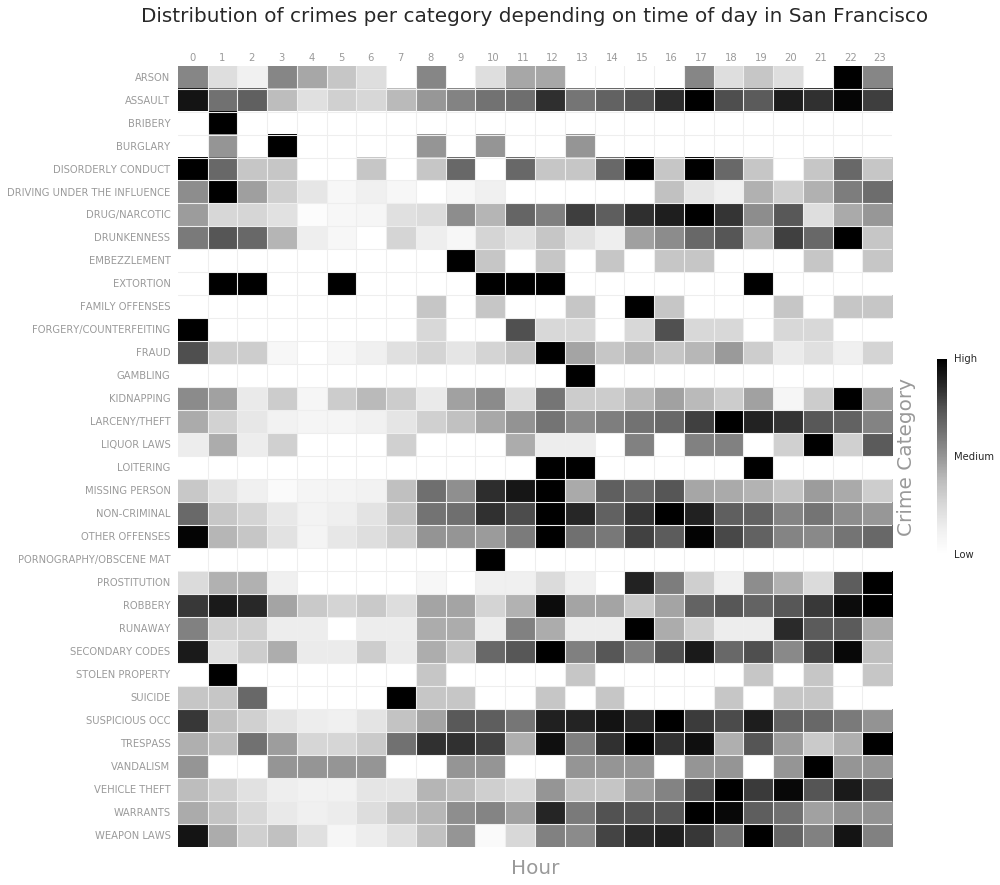

In [39]:
# draw grid on axes
fig, ax = preparePlot(np.arange(.5, 23, 1), np.arange(.5, n_categories-1, 1), figsize=(16,14), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_src, interpolation='nearest', aspect='auto', cmap=cm.Greys)

# x-axis labels
for x, y, s in zip(np.arange(-.125, 24, 1), np.repeat(-.75, 24), [str(x) for x in range(24)]):
    plt.text(x, y, s, color='#999999', size='10')
# y-axis labels
for x, y, s in zip(np.repeat(-.75, n_categories), np.arange(.125, n_categories, 1), categories):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="right")
plt.title("Distribution of crimes per category depending on time of day in San Francisco", size=20, y=1.05)
plt.xlabel("Hour", color='#999999', size="20")
plt.ylabel("Crime Category", color='#999999', size="20")
ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()

From that plot, a few interesting properties emerge:

* A common property to most crime categories is that between 4am and 6am the number of crime occurrences drops drastically. This can easily be explained by the fact that people are mostly sleeping during that time, so it is to be expected.
* Some crimes are most common during the day between 10am and 6pm, while others are most commong during the evening/night between 6pm and 6am.

Since our goal here is to look at crimes happening at night, let's take a closer look at the crimes we can identify:

* Occurrences of `ASSAULT` crimes are constant overall throughout the day, but there is a distinct increase after 4pm, a peak around 10pm and then it goes back to normal after 2am.
* `DRUNKENNESS` has a low number of occurrences in the day before 4pm, then steadily increases and peaks around 10pm before going back to normal around 3am.
* For `LARCENY/THEFT` crimes, the number of occurrences gradually, almost linearly, increases throughout the day, reaching critical mass around 5pm, peaking around 7pm, and then going down around midnight-1am.
* `PROSTITUTION` seems to be almost non-existent during the day, but there are some distinct occurrences at night, especially close to midnight.
* There is a pretty clear pattern for `ROBBERY`: the number of occurrences starts growing at 5-6pm, peaking around midnight, and falling flat around 2am. This makes sense, robberies are more likely to happen when shops are closed.
* `VEHICLE THEFT` seems to be mostly concentrated between 5pm and midnight. This makes sense intuitively, people are more likely to steal cars when it is dark and when their owners are at home after work.

### Geospatial Analysis - Crimes by San Francisco Neighborhood

Now we have identified which crimes are more common at night, and we want to focus on those and dig further.

In particular, it would be interesting to see how these crimes are distributed geographically, and see if we can create a map of San Francisco's criminality at night and which neighborhoods to avoid. We have the `Longitude` and `Latitude` columns in our `dataset` DataFrame which can help us, but we don't really have a map of San Francisco.

Plotting geospatial data is not a trivial topic, thankfully several libraries exist in Python that we use in this analysis:

* `matplotlib`'s [basemap](http://matplotlib.org/basemap/) toolkit: This is useful to plot 2D map data, but doesn't provide much facility around that.
* [fiona](https://github.com/sgillies/Fiona) is a Python interface to [OGR](http://www.gdal.org/ogr/). We use it to open [Shapefiles](https://en.wikipedia.org/wiki/Shapefile) representing San Francisco.
* [shapely](http://toblerity.github.com/shapely/) is a library for analyzing and manipulating planar geometric objects in Python. In particular, it is useful to create polygons and points, which for us maps to neighborhoods and crime occurrences.
* [descartes](https://pypi.python.org/pypi/descartes) is a Python library allowing us to manipulate geospatial shapes. This is useful to turn `shapely` polygons into `matplotlib` patches to be represented on maps.
* [PySAL](https://pysal.readthedocs.org/en/latest/) is a spatial analysis library - we use it here to cluster neighborhoods based on the number of crimes.

Some interesting analyses that I drew from:

* [London Blue Plaque Analysis](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html)
* [San Francisco's Drug Geography](http://lmart999.github.io/2015/02/28/gis/)

Let's import all of these modules right now to make sure all is working - some of these have complex and long installation procedures, so we should check they are working before starting:

In [41]:
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain

import fiona

Before we can get started, we need an extra dataset aside from the San Francisco crime data.

In order to draw a map of San Francisco, the easiest way is to leverage `fiona` and use a _shapefile_ of San Francisco. One such shapefile is available on [SF's open-data portal](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SFFind-Neighborhoods/ejmn-jyk6) and has been downloaded in this repository under **data/SFFind_Neighborhoods**

Let's read it with Fiona:

In [45]:
SF_NEIGHBORHOODS = "sffind_neighborhoods"
sf_neighborhoods = os.path.join(DATA_DIR, "%s.shp" % SF_NEIGHBORHOODS)
shp = fiona.open(sf_neighborhoods)

Now that we have successfully read the shapefile, we need to pre-compute some statistics which will be used to construct our map:

* Map boundaries: used to define what to display.
* Width, height: used to center the plot.

In [43]:
# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

Now we have enough data to create a `matplotlib` `Basemap` object which is the foundation of our map. Here we need to specify some geospatial parameters like which projection to use, as well as latitude and longitude coordinates for our map and where it should be centered.

On top of that, we overlay the content of our shapefile so we have the starting point for our `Basemap`.

Read SF neighborhood data into Basemap


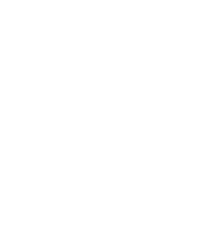

In [50]:
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    os.path.join(DATA_DIR, SF_NEIGHBORHOODS),
    'SF',
    color='none',
    zorder=2)

print "Read SF neighborhood data into Basemap"

Next we need to create a DataFrame representing our map data on which we can apply operations. This DataFrame will contains `Polygon` objects via `shapely` where each `Polygon` represents a San Francisco neighborhood.

In this DataFrame we also want to include geographic information like the area size in meters and kilometers, because ultimately we will want to represent the crime density by neighborhood.

In [56]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))

df_map.sample(n=5)

,poly,ward_name,area_m,area_km,patches
25,"POLYGON ((7769.153567631431 8061.607089117261,...",Mint Hill,152987.583591,1.529876,"Poly((7769.15, 8061.61) ...)"
31,"POLYGON ((9889.314417675589 8270.287161577276,...",Showplace Square,634667.168818,6.346672,"Poly((9889.31, 8270.29) ...)"
93,"POLYGON ((6759.950193215322 4346.840614139207,...",Glen Park,897055.715613,8.970557,"Poly((6759.95, 4346.84) ...)"
102,"POLYGON ((9379.862575733292 10114.98997244424,...",Nob Hill,639541.819161,6.395418,"Poly((9379.86, 10115) ...)"
39,"POLYGON ((3957.991027576041 3497.675395709491,...",Stonestown,696463.340511,6.964633,"Poly((3957.99, 3497.68) ...)"


Finally, we need some data to plot ! We can use our `dataset` DataFrame and convert the `Longitude` and `Latitude` columns to `shapely` `Point` and `MultiPoint` which will be the basis for drawing on our `Basemap`.

We need to make sure that what we select the right data from our `dataset` DataFrame before transforming it to `Points`:

* Only San Francisco data.
* Category should be within the list of 6 crime categories we have identified as happening mostly at night (`ASSAULT`, `DRUNKENNESS`, `LARCENY/THEFT`, `PROSTITUTION`, `ROBBERY`, `VEHICLE THEFT`)
* Occurrences should have a time between 6pm and 6am (this is what we consider as evening/night in this analysis)

In [58]:
def makePoints(dat):
    # Create Point objects in map coordinates from dataframe lon and lat values
    map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(dat['Longitude'],dat['Latitude'])])
    plt_points = MultiPoint(list(map_points.values))
    hoods_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    pts = filter(hoods_polygon.contains,plt_points)
    return pts

night_categories = [
    "VEHICLE THEFT", 
    "ROBBERY", 
    "PROSTITUTION", 
    "LARCENY/THEFT",
    "DRUNKENNESS",
    "ASSAULT"
]

sf_night_crimes = dataset[
                            (dataset["City"] == SF) & 
                            (
                                (dataset["TimeBin"] >= 18) | 
                                (dataset["TimeBin"] <= 6)
                            ) & 
                            (dataset["Category"].isin(night_categories))]
sf_night_vehicle_theft = sf_night_crimes[sf_night_crimes["Category"] == night_categories[0]]
sf_night_robbery = sf_night_crimes[sf_night_crimes["Category"] == night_categories[1]]
sf_night_prostitution = sf_night_crimes[sf_night_crimes["Category"] == night_categories[2]]
sf_night_theft = sf_night_crimes[sf_night_crimes["Category"] == night_categories[3]]
sf_night_drunk = sf_night_crimes[sf_night_crimes["Category"] == night_categories[4]]
sf_night_assault = sf_night_crimes[sf_night_crimes["Category"] == night_categories[5]]

sf_night_crimes_points = makePoints(sf_night_crimes)
sf_night_vehicle_theft_points = makePoints(sf_night_vehicle_theft)
sf_night_robbery_points = makePoints(sf_night_robbery)
sf_night_prostitution_points = makePoints(sf_night_prostitution)
sf_night_theft_points = makePoints(sf_night_theft)
sf_night_drunk_points = makePoints(sf_night_drunk)
sf_night_assault_points = makePoints(sf_night_assault)

Let's recap where we are at this point:

* We have our `Basemap` instance created, with our neighborhood shapefile overlay.
* We have a list of `Points` for each of our night crime.

All that is left is to `scatter` the individual crime `Points` in the map and render them on top of the `Basemap` to have a geospatial visualization of our crime occurrences at night.

Some considerations used here to produce a visually pleasing visualization:

* Categories like `PROSTITUTION`, `DRUNKENNESS` and `ROBBERY` which are less frequent have a bigger scatter plot size so they don't disappear under the way more frequent `ASSAULT`, `LARCENY/THEFT` and `VEHICLE THEFT`.
* `LARCENY/THEFT` has quite a bit of overlap with the other categories, so it is represented with a cross (**x**) instead of a dot (**o**) like the others, in order to being able to distinguish every category.

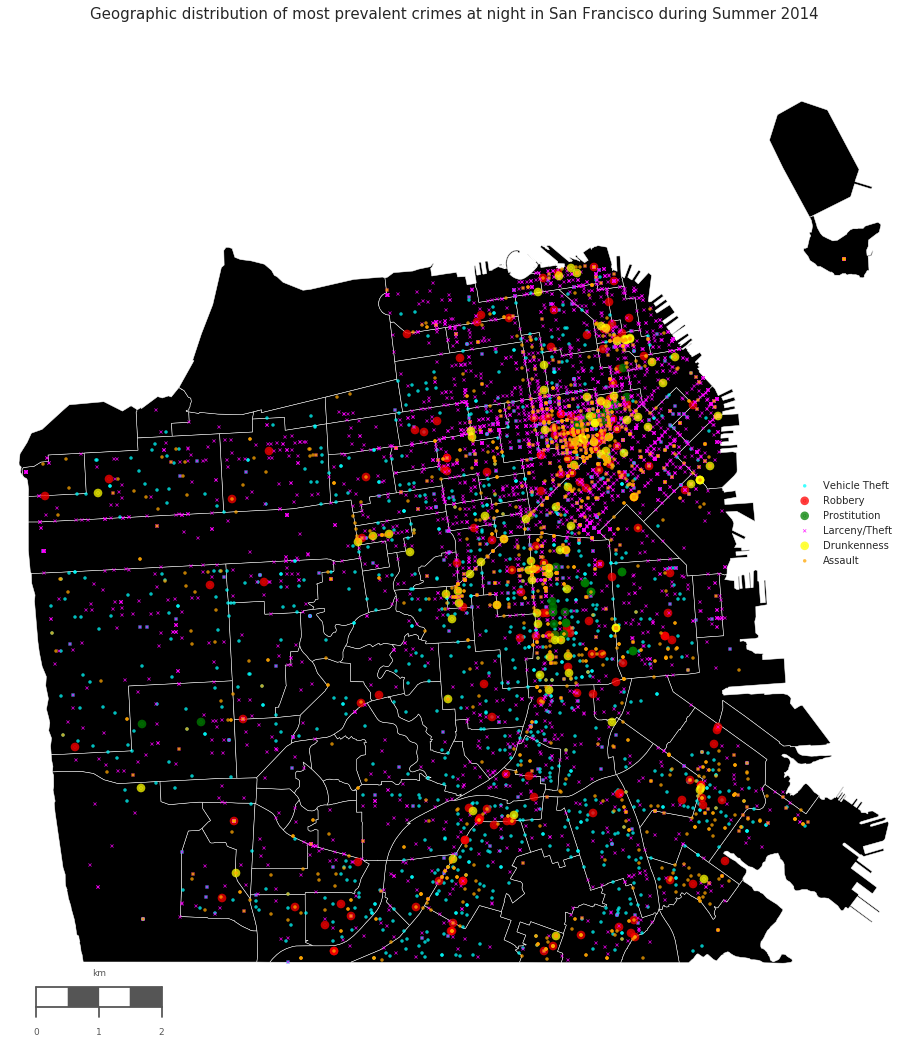

In [61]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# Scatter vehicle theft occurrences
dev = m.scatter(
    [geom.x for geom in sf_night_vehicle_theft_points],
    [geom.y for geom in sf_night_vehicle_theft_points],
    10, marker='o', lw=.25,
    facecolor='cyan', edgecolor='cyan',
    alpha=0.75, antialiased=True,
    label='Vehicle Theft', zorder=3)

# Scatter robbery occurrences
dev = m.scatter(
    [geom.x for geom in sf_night_robbery_points],
    [geom.y for geom in sf_night_robbery_points],
    10, marker='o', lw=5.5,
    facecolor='red', edgecolor='red',
    alpha=0.75, antialiased=True,
    label='Robbery', zorder=3)

# Scatter prostitution occurrences
dev = m.scatter(
    [geom.x for geom in sf_night_prostitution_points],
    [geom.y for geom in sf_night_prostitution_points],
    10, marker='o', lw=5.5,
    facecolor='green', edgecolor='green',
    alpha=0.75, antialiased=True,
    label='Prostitution', zorder=3)

# Scatter larceny/theft occurrences
dev = m.scatter(
    [geom.x for geom in sf_night_theft_points],
    [geom.y for geom in sf_night_theft_points],
    10, marker='x', lw=.75,
    facecolor='magenta', edgecolor='magenta',
    alpha=0.75, antialiased=True,
    label='Larceny/Theft', zorder=3)

# Scatter drunkenness occurrences
dev = m.scatter(
    [geom.x for geom in sf_night_drunk_points],
    [geom.y for geom in sf_night_drunk_points],
    10, marker='o', lw=5.5,
    facecolor='yellow', edgecolor='yellow',
    alpha=0.75, antialiased=True,
    label='Drunkenness', zorder=3)

# Scatter assault occurrences
dev = m.scatter(
    [geom.x for geom in sf_night_assault_points],
    [geom.y for geom in sf_night_assault_points],
    10, marker='o', lw=.25,
    facecolor='orange', edgecolor='orange',
    alpha=0.75, antialiased=True,
    label='Assault', zorder=3)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of most prevalent crimes at night in San Francisco during Summer 2014", size=15)
fig.set_size_inches(15,15)
plt.show()

So what does this map tell us? We can make plenty of observations now that we have a geospatial representation of crimes and their neighborhoods:

* A lot of crime activity is concentrated in the city center near Union Square, for all of the categories identified here.
* `ASSAULT` crimes seem to be particularly prevalent in the Tenderloin neighborhood. This makes sense, since the Tenderloin has a reputation to be a pretty sketchy neighborhood.
* `PROSTITUTION` is not found so much in the city center, but seems to be more concentrated around the Mission district. This also makes sense, because Capp Street has a reputation of having many prostitutes, so the data correlates with this story.
* For `ROBBERY` occurrences, they are pretty sparsely distributed accross the city and there is no real epicenter. But what we can clearly see is that the further West we go, the fewer robberies there are.
* `VEHICLE THEFT` and `LARCENY/THEFT` are happening pretty much uniformly everywhere in the city. The frequency is of course higher in the city center, but this is more due to it being more densely populated than anything else.
* Based on the occurrences of `DRUNKENNESS`, you can find more drunk people alongside the main big streets like Market Street. This makes sense because this is probably where most bars are located.

This was a useful visualization, but we're not done yet. One of our goals was to see which neighborhoods to avoid at night. And, while we can start forming a pretty good idea at that point, it would be nice to cluster the different neighborhoods based on their crime density, and represent that on the map.

To that end we will use a classification algorithm called [Jenks Natural Breaks Optimization](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) which will take all our neighborhoods and their crime densities, and divide these into several crime categories.

The first step is to take our night crime data (for all 6 night crime categories), and identify to which neighborhood they belong, count those, and derive the crime density from it:

In [66]:
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, sf_night_crimes_points))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

df_map.sample(n=5)

,poly,ward_name,area_m,area_km,patches,count,density_m,density_km,jenks_bins
112,"POLYGON ((7201.553898320555 6993.663623664478,...",Corona Heights,284539.649087,2.845396,"Poly((7201.55, 6993.66) ...)",16,0.000056,5.623118,2
80,"POLYGON ((8723.906356908104 4379.785139743365,...",Bernal Heights,1726501.858500,17.265019,"Poly((8723.91, 4379.79) ...)",124,0.000072,7.182153,2
49,"POLYGON ((7411.695590399388 6809.613762564126,...",Dolores Heights,932400.338363,9.324003,"Poly((7411.7, 6809.61) ...)",49,0.000053,5.255253,2
32,"POLYGON ((10855.28558989381 7127.391250561395,...",Mission Bay,1603861.759928,16.038618,"Poly((10855.3, 7127.39) ...)",36,0.000022,2.244582,0
37,"POLYGON ((385.6818079737714 7168.304898396558,...",Outer Sunset,7051751.539869,70.517515,"Poly((385.682, 7168.3) ...)",142,0.000020,2.013684,0


Next we use `PySAL` which has an implementation of the Natural Breaks algorithm, and apply it to the crime density per square kilometer, and ask the algorithm to divide the neighborhoods in 5 classes.

In [69]:
from pysal.esda.mapclassify import Natural_Breaks as nb

# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)

prev = 0
for density, counts in zip(breaks.bins, breaks.counts):
    print "%d neighborhoods have crime density D such as %d/km^2 <= D <= %d/km^2" % (counts, prev, density)
    prev = density

36 neighborhoods have crime density D such as 0/km^2 <= D <= 2/km^2
21 neighborhoods have crime density D such as 2/km^2 <= D <= 4/km^2
26 neighborhoods have crime density D such as 4/km^2 <= D <= 9/km^2
22 neighborhoods have crime density D such as 9/km^2 <= D <= 24/km^2
8 neighborhoods have crime density D such as 24/km^2 <= D <= 86/km^2


From that, we join back the results of the Natural Breaks algorithm with our map DataFrame so that we know for each neighborhood what its class is. This is all we need in terms of data, based on that we will be able to assign different colors to each neighborhood based on their class.

We also want to create the labels for the color scale based on the density values found by the algorithm, so we can show in the map to what density each color corresponds.

In [70]:
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
df_map.drop("jenks_bins", inplace=True, axis=1, errors="ignore")
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

# assign labels to the colorbar based on the natural breaks bins
jenks_labels = ["<= %0.1f crimes / km$^2$" % b for b in breaks.bins]
jenks_labels.insert(0, 'No crimes')

Finally all that's left to do is to draw the map and assign the right colors ! We will use the `Blues` colormap which is more aesthetically pleasing.

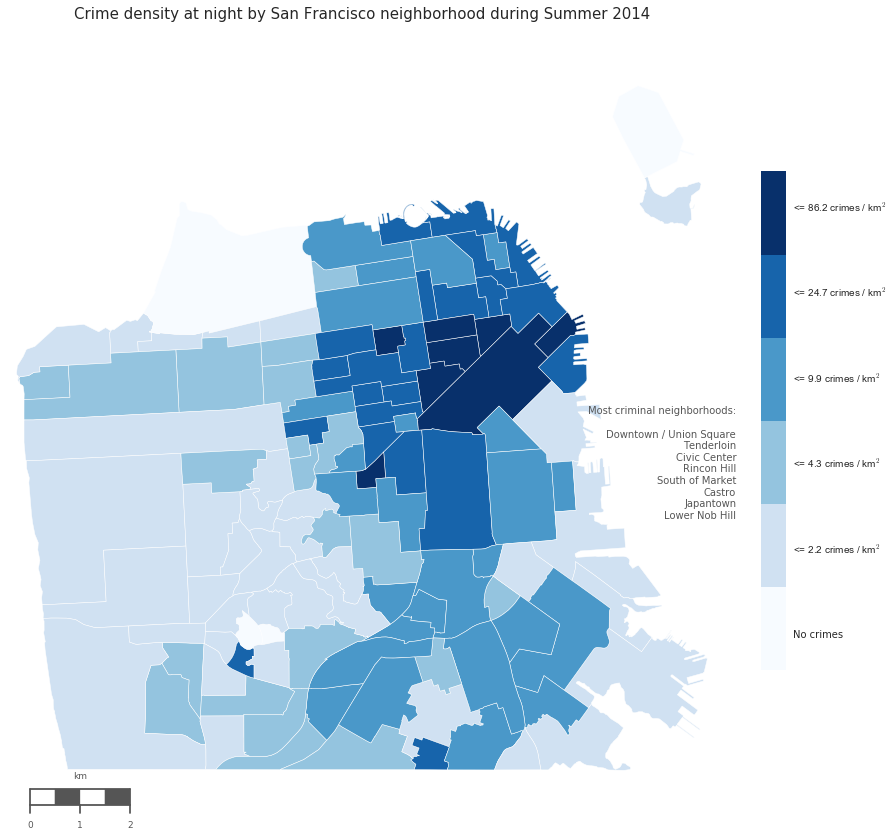

In [72]:
from matplotlib.colors import Normalize, LinearSegmentedColormap 

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=10)

# Show highest densities, in descending order
highest = '\n'.join(
    value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
highest = 'Most criminal neighborhoods:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    -1., 0 + 0.3,
    highest,
    ha='right', va='bottom',
    size=10,
    color='#555555')

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.tight_layout()
plt.title("Crime density at night by San Francisco neighborhood during Summer 2014", size=15)
fig.set_size_inches(15, 15)
plt.show()

This map is much easier to parse visually than the previous map. It contains less information, but information is aggregated and tells a clearer story with no need for interpretation.

Here we can see that the most criminal neighborhoods are, for most of them, right in the city center. This can be explained by the fact that this area is more densely populated, and also where most activities at night happen, so this was expected.

What is interesting to notice though is that, even though they are both far from the city center, Western San Francisco (The Avenues + Twin Peaks) and SouthEast districts have very different crime patterns: there are way more crimes in the SouthEast, than there are in the West.

### Comparison between San Francisco and Seattle crime distribution

At that point we have a pretty good understanding of crime activity at night in San Francisco, both temporally and spacially. What would now be interesting to see is if there is any correlation between what we've found in San Francisco, and crime data in Seattle.

We already did the groundwork during pre-processing to normalize Seattle and San Francisco's datasets, so it is now a simple matter of visualizing what we previously did.

An interesting way to show the differences in crime distribution between the 2 cities is to use hierarchical clustering on normalized crime occurrences broken down by category. Thankfully Python's library [seaborn](https://github.com/mwaskom/seaborn) provides powerful visualization techniques and, among those, a `clustermap` which essentially uses hierarchical clustering to discover relationships between rows and columns in a DataFrame.

The first step is to prepare our data: we want to create a DataFrame where each row represents a category, and each column a different city. A few extra processing steps:

* If a crime category doesn't have an occurrence in both cities, we take it out. It wouldn't be meaningful to include it since we are comparing both cities.
* We need to normalize the values accross rows so that crimes with very high occurrences like `LARCENY/THEFT` don't end up alone in a cluster and everything else in a separate cluster. The sum of each row should be 1.

In [84]:
# only keep night crimes
gb = dataset[(dataset["TimeBin"] >= 18) | (dataset["TimeBin"] <= 6)].groupby("Category")
category_by_city = gb["City"].value_counts().unstack().fillna(0)
# filter out crimes which don't have an occurrence in both cities
category_by_city_nonnull = category_by_city[(category_by_city[SF] > 0) & (category_by_city[SEATTLE] > 0)]
print category_by_city[(category_by_city[SF] == 0) | (category_by_city[SEATTLE] == 0)]
# normalize the distribution of crimes so that each rows adds up to 1
category_by_city_norm = category_by_city_nonnull.div(category_by_city_nonnull.sum(axis=1), axis=0)

category_by_city_norm.sample(n=5)

                 sanfrancisco  seattle
Category                              
BRIBERY                     1        0
DRUNKENNESS                98        0
EXTORTION                   4        0
FAMILY OFFENSES             3        0
KIDNAPPING                 63        0
LOITERING                   1        0
MISSING PERSON            401        0
SECONDARY CODES           216        0
SUICIDE                     7        0
SUSPICIOUS OCC            562        0


,sanfrancisco,seattle
Category,,
BURGLARY,0.001778,0.998222
WEAPON LAWS,0.712687,0.287313
ASSAULT,0.536783,0.463217
LIQUOR LAWS,0.457627,0.542373
RUNAWAY,0.888889,0.111111


We are now ready to plot our `clustermap`, still using the `Blues` colormap for consistency with what we did previously:

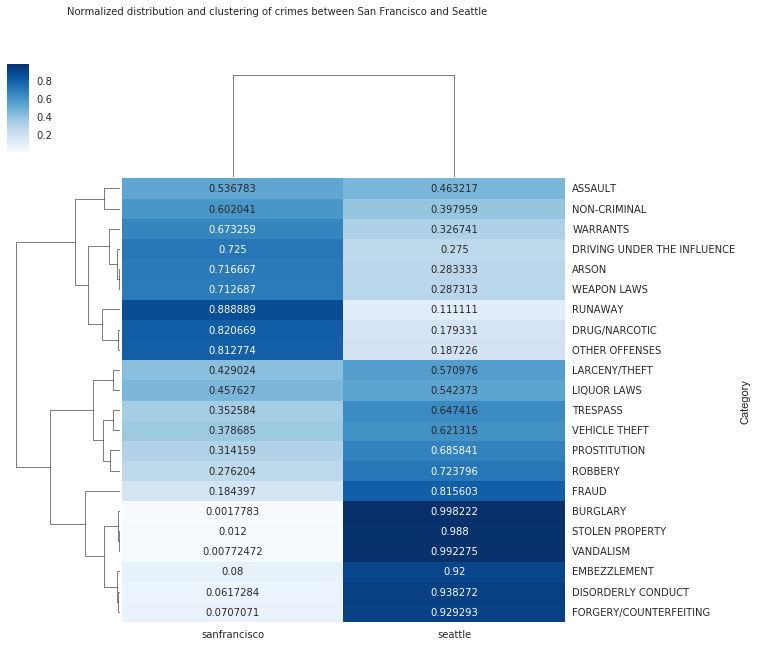

In [85]:
import seaborn as sns

g = sns.clustermap(category_by_city_norm, annot=True, cmap="Blues", fmt="g")
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
g.fig.suptitle("Normalized distribution and clustering of crimes between San Francisco and Seattle", size=15)
plt.show()

The `clustermap` has rearranged the order of the categories to exhibit the different clusters. We can quite clearly here see 3 different clusters emerge:

* A cluster where the proportion of occurrences is roughly the same between the 2 cities.
* A cluster where the proportion of occurrences is significantly higher in Seattle.
* A cluster where the proportion of occurrences is significantly higher in San Francisco.

Let's look at our night categories again:

* `ASSAULT`: 0.54 (SF) ~= 0.46 (Seattle)
* `DRUNKENNESS`: not in Seattle, probably due to the way we manually labelled the Seattle categories, or could already be labbeled by SeattlePD under different categories.
* `LARCENY/THEFT`: 0.43 (SF) ~= 0.57 (Seattle)
* `PROSTITUTION`: 0.31 (SF) < 0.69 (Seattle)
* `ROBBERY`: 0.28 (SF) < 0.72 (Seattle)
* `VEHICLE THEFT`: 0.38 (SF) < 0.62 (Seattle)

`ASSAULT` and `LARCENY/THEFT` are by far the most frequent crime categories (see previous map to convince yourself), so it makes sense that they are roughly similar between the 2 cities because it is statistically significant.
For the other categories however they are far lower in San Francisco than in Seattle. There are multiple ways to explain that:

* We got about 4,000 more crime entries in the initial datasets for Seattle than in San Francisco.
* We manually re-labelled the crime categories in Seattle, and might have inflated some categories numbers.

## Conclusion

In this analysis we discovered the following facts:

* Certain crime categories such as robberies, assault, theft, prostitution and drunkenness happen mostly in the evening/night in San Francisco.
* These crimes happen mostly in the city center and southeast parts of San Francisco at night, but the west side is relatively safe at night.
* Violent crimes such as assault happen as often at night in San Francisco as in Seattle (with a slight edge to San Francisco), but non-violent crimes happen more often in Seattle.